In [1]:
from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')


import os
import networkx as nx
from networkx.algorithms import bipartite

## Affiliation and bipartite graphs

Today, we're going to study *affiliation networks*. Affiliation networks can be used to describe the relationships between two different types of nodes. Some common examples:

* people who attend events
* people who belong to groups

Affiliation networks can be represented by *bipartite graphs*. Bipartite graphs are like other mathematical graphs, but they have an additional property: the nodes in the graph can be divided into two sets, say A and B, such that every edge in the graph connects a node from A to a node from B. 

In addition to affiliation networks, some other types of networks that can be represented as bipartite graphs are:

* people who work together on a project (such as a scientific paper or a movie)
* people who buy a product
* people who read an article

These networks are different from what we have seen before because there are really two types of nodes: one type of node is a person, but another type of node is an event / group / product / etc.  Researchers call these *two-mode* networks.  Networks that can be represented with bipartite graphs are often two-mode.

### Example: birthday parties

Here is an example of an affiliation network (from pg 299 of *Social Network Analysis* by Wasserman and Faust):

<img src="affiliation_example_wassermanfaust.png">

The rows in the table above represent one kind of node (children), and the columns represent the second kind of node (parties). A 1 at position $(i,j)$ in the table means that child represented by row $i$ attended the party represented by column $j$. A 0 means the child did not attend the party.

We can represent this network as a bipartite graph like this (ibid, pg 301):

<img src="affiliation_example2_wassermanfaust.png">

Let's enter this graph into networkx using an edge list:

In [2]:
bday_net = nx.Graph([('A', '1'), ('A', '3'), ('D', '2'), ('E', '2'), ('E', '3'), ('K', '3'), ('R', '1'), ('R', '2'), ('R', '3'), ('S', '1'), ('S', '2')])

We have to do a bit of extra work to tell `networkx` that this graph is bipartite. We'll pass the names of the nodes in one of the bipartite sets like so:

In [3]:
bday_child_nodes = ['A', 'D', 'E', 'K', 'R', 'S']
bday_party_nodes = ['1', '2', '3']

#bday_net = nx.Graph()

# bipartite=0 tells networkx that these nodes are one of the independent sets of the bipartite network;
bday_net.add_nodes_from(bday_child_nodes, bipartite=0)
# the other independent set will have bipartite=1
bday_net.add_nodes_from(bday_party_nodes, bipartite=1)

We can double-check that we've created a bipartite network with `nx.is_bipartite`:

In [4]:
nx.is_bipartite(bday_net)

True

And we can have `networkx` draw it -- but we'll have to jump through a couple of hoops to force networkx to put one independent set of nodes on the left and the other independent set of nodes on the right:

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


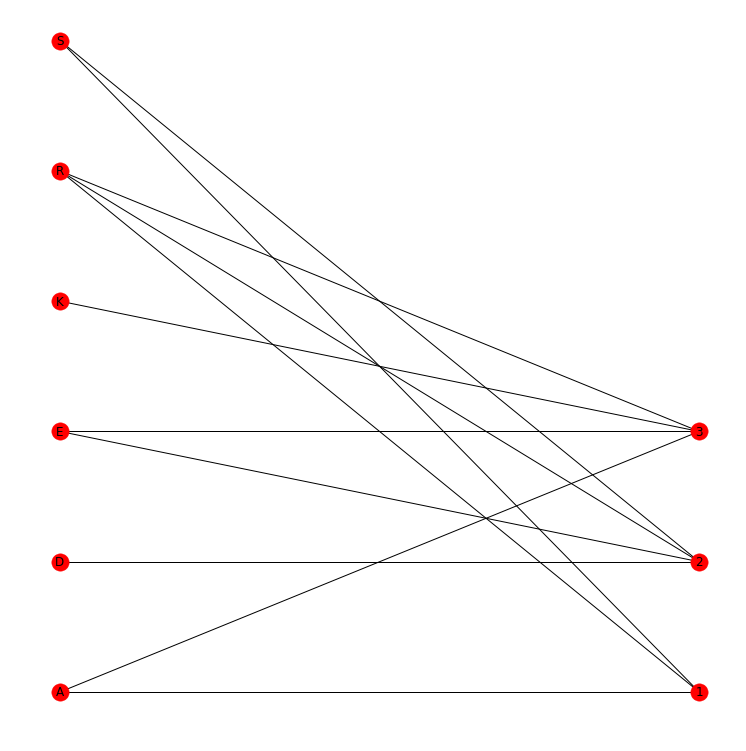

In [5]:
bday_pos = dict()

for idx, node_id in enumerate(bday_child_nodes):
    bday_pos[node_id] = (1, idx)
    
for idx, node_id in enumerate(bday_party_nodes):
    bday_pos[node_id] = (2, idx)

plt.figure(figsize=(10,10))
nx.draw(bday_net, pos=bday_pos, with_labels=True)

In order to get information about the degrees of each half of the network, we can give the `nx.degree` function a list of node ids. The result is a dictionary, so if we just want a list of the degrees themselves, we use `.values()`. All in all, this is a pattern for getting the degrees in each independent set:

In [9]:
child_degrees = dict(nx.degree(bday_net, bday_child_nodes)).values()
party_degrees = dict(nx.degree(bday_net, bday_party_nodes)).values()

Many functions in the `networkx` package will let you pass in a list of node ids like `nx.degree` does.

### Example: average clustering

To illustrate how affiliation networks are somewhat different from the other networks we have seen so far, we'll use the concept of network *average clustering*. We discussed this in a previous lab; conceptually, the clustering coefficient of an individual node captures the extent to which that nodes friends are friends with each other. The average clustering of a network is the average of the clustering coefficient over all of the individual nodes.

In a one-mode network (like all of the ones we have seen before today), the clustering coefficient can be calculated like this:

$$C(v) = \frac{\text{# edges between node $v$'s friends}}{\text{max # possible edges between node $v$'s friends}}$$

This is problematic in the case of a bipartite network. Can you see why?

**Discussion Question** Would this metric work in an affiliation network? Why or why not?

[Latapy et al](http://www.sciencedirect.com/science/article/pii/S0378873307000494) have proposed an alternative metric for clustering in a bipartite graph. First, they define a metric for overlap; for any pair of nodes $u$ and $v$ that are in the same independent set,

$$overlap(u, v) = \frac{\text{# neighbors u and v share}}{\text{max # neighbors u and v could share}}$$

At most, this value is $1$ (when both nodes have exactly the same set of neighbors); at least, this value is $0$ (when the two nodes have no neighbors in common).

The bipartite clustering coefficient for one node $u$ is then defined to be

$$C_{b}(u) = \frac{\text{sum of overlap between $u$ and all other nodes that are 2 steps away from $u$}}{\text{# nodes that are 2 steps away from u}}$$

The average bipartite clustering coefficient is then the average of this quantity over all of the nodes in the network. This quantity will range from 0 (no clustering) to 1 (perfect clustering).

We don't need to dwell on how this metric is constructed; for our purposes today, there are two important lessons:

* network metrics like clustering can't necessarily be meaningfully used in two-mode networks
* but it is often possible to come up with a metric that gets at the same idea

### Bipartite projections

Two-mode bipartite networks can be transformed into one-mode networks by *projecting* them. In the example above, we could create a network whose nodes are children, where two children are connected by an edge if they attended the same birthday party.

**Question** What are the edges in the one-mode projection of the birthday party affiliation network onto the child nodes? (You can write out the edge list.)

**Question** Use the `networkx` function `bipartite.projected_graph` to check your answer

In [10]:
bday_child_net = bipartite.projected_graph(bday_net, bday_child_nodes)
bday_child_net.edges()

EdgeView([('A', 'S'), ('A', 'K'), ('A', 'R'), ('A', 'E'), ('D', 'S'), ('D', 'R'), ('D', 'E'), ('E', 'R'), ('E', 'S'), ('E', 'K'), ('K', 'R'), ('R', 'S')])

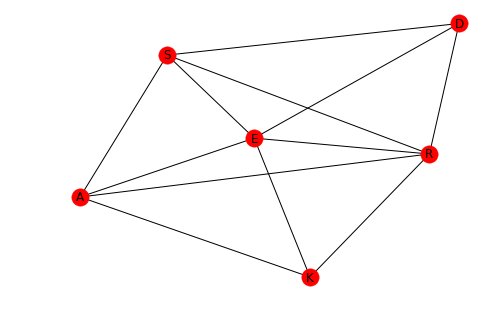

In [11]:
nx.draw(bday_child_net, with_labels=True)

Creating the projected network threw away a lot of information; for example, two children who both attended the exact same set of parties can't be distinguished from two children who just attended one same party. (Be sure you see why.)


One way to keep more information about the structure in the bipartite network is to weight the edges in the projected network (ie, assign them numerical values). What should the weights be? Well, that depends; there are lots of options, and it generally makes sense to use what you know about the substantive problem you are working on to figure out what the best way to generate weights is. Here, we'll start with a very simple procedure: we will weight the edge by the number of events that the two nodes co-attended.

**Question** Add weights to the edges of the projected network that you made above (the one you made by hand).

**Question** The `networkx` function `bipartite.weighted_projected_graph` will calculate this weighted projected network for you. Use it to check your work.

In [12]:
bday_child_net2 = bipartite.weighted_projected_graph(bday_net, bday_child_nodes)
bday_child_net2.edges(data=True)

EdgeDataView([('A', 'S', {'weight': 1}), ('A', 'K', {'weight': 1}), ('A', 'R', {'weight': 2}), ('A', 'E', {'weight': 1}), ('D', 'S', {'weight': 1}), ('D', 'R', {'weight': 1}), ('D', 'E', {'weight': 1}), ('E', 'R', {'weight': 2}), ('E', 'S', {'weight': 1}), ('E', 'K', {'weight': 1}), ('K', 'R', {'weight': 1}), ('R', 'S', {'weight': 2})])

### The Southern Women dataset

Below is an example of a famous affiliation matrix originally collected by Davis and colleagues (Davis, Gardner and Gardner, 1941, *Deep South: A Social Anthropological Study of Caste and Class*).  The rows of the matrix below correspond to eighteen women in a southern town, while the columns correspond to 14 different social events. An entry in the matrix is 1 if the corresponding woman attended the corresponding event, and 0 otherwise.

<img src="southern_women_matrix_breiger1974.png">

The Koblenz Network Collection has [digitized](http://konect.uni-koblenz.de/networks/opsahl-southernwomen) this network; we'll read it in now.

In [13]:
sw_dat = []
with open(os.path.join("data", "southern-women", "southernwomen.tsv")) as f:
    for line in f:
        # lines beginning with '%' are comments
        if line[0] == '%':
            continue
        sw_dat.append(line.strip())

# by default, the nodes are just numbers; we'll make them more descriptive
# to avoid confusion later on in our analysis
sw_edges = [(("woman_" + (str.split(x)[0])), ("event_" + (str.split(x)[1]))) for x in sw_dat]

all_women = list(set(x[0] for x in sw_edges))
all_events = list(set(x[1] for x in sw_edges))

Similar to the process we used with the birthday party attendance, above, we'll create a bipartite `networkx` graph using the edgelist and information about which node is in which independent set.

In [14]:
sw_net = nx.Graph()
sw_net.add_nodes_from(all_women, bipartite=0)
sw_net.add_nodes_from(all_events, bipartite=1)
sw_net.add_edges_from(sw_edges)

**Question** Draw the network using a non-bipartite method (like `nx.draw_spring`, for example). Is it easy to tell that this network is bipartite from the picture?

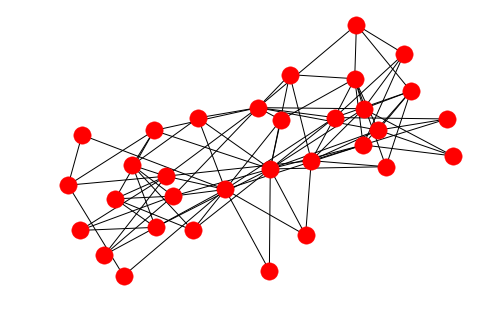

In [15]:
nx.draw_spring(sw_net)

**Question** Now plot this network explicitly accounting for the bipartite structure: adapt the code above to be sure that all of the nodes representing women are on the left and all of the nodes representing events are on the right.

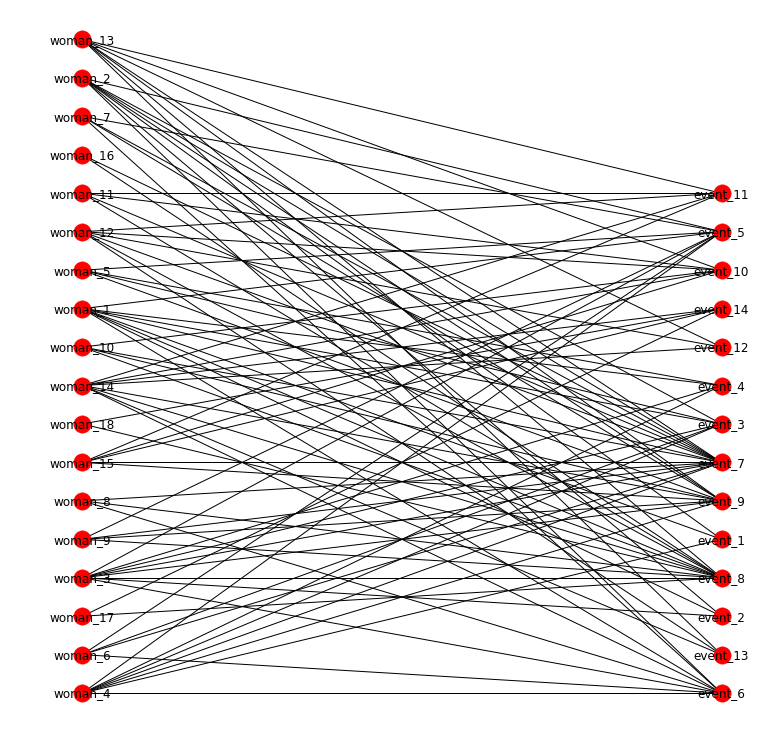

In [16]:
sw_pos = dict()

for idx, node_id in enumerate(all_women):
    sw_pos[node_id] = (1, idx)
    
for idx, node_id in enumerate(all_events):
    sw_pos[node_id] = (2, idx)

plt.figure(figsize=(10,10))
nx.draw(sw_net, pos=sw_pos, with_labels=True)

### Bipartite random networks

Above, we saw that the metric for network density had to be modified to account for the constraint that edges can only go from one independent set to another. The same is true of the ER random network model: the ER model we have studied so far could generate an edge between any pair of nodes in the network. By constraining the model so that it can only generate edges between the two independent sets, we obtain a bipartite random network model.

The function below takes a network passed in as an argument, and generates a 'matching' bipartite random network; that is, it returns a randomly generated bipartite random network that has the same number of nodes in each independent set, and the same average degree for nodes in each independent set.

In [17]:
def matching_bipartite_random_net(net):
    nodes0, nodes1 = bipartite.sets(net)
    observed_p = bipartite.density(net, nodes0)
    generated_net = bipartite.random_graph(len(nodes0), len(nodes1), observed_p)
    
    # we have to jump through some hoops to have nodes whose ids match the original network
    # (but this can be convenient, so we'll do it)
    n0 = len(nodes0)
    n1 = len(nodes1)
    generated_net = nx.relabel_nodes(generated_net, dict(zip(range(n0), nodes0)))
    generated_net = nx.relabel_nodes(generated_net, dict(zip(range(n0, n0+1+n1), nodes1)))
    
    return(generated_net)
    

Here's a helper function that will save you having to re-type the bipartite plotting code. Study it to see how it works; look at the help page for `bipartite.sets` to be sure you understand what it does.

In [18]:
def draw_bipartite_net(net):
    
    net_pos = dict()

    nodes0, nodes1 = bipartite.sets(net)
    
    for idx, node_id in enumerate(nodes0):
        net_pos[node_id] = (1, idx)

    for idx, node_id in enumerate(nodes1):
        net_pos[node_id] = (2, idx)

    plt.figure(figsize=(10,10))
    nx.draw(net, pos=net_pos, with_labels=True)

**Question** Generate one bipartite random network that matches the Southern Women network in terms of the number of nodes and average degree in each independent set. Then use `draw_bipartite_net` to plot it.

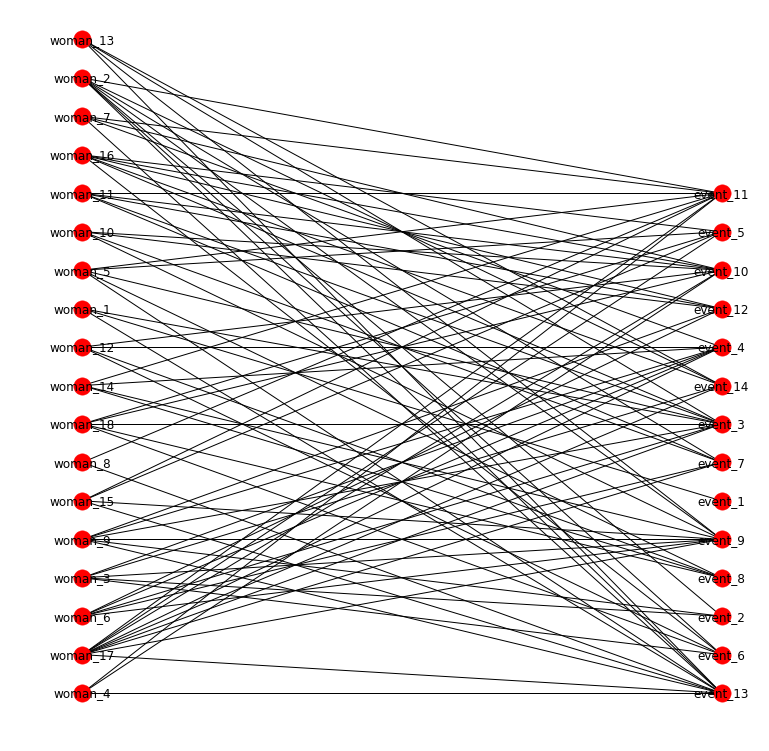

In [24]:
test = matching_bipartite_random_net(sw_net)
draw_bipartite_net(test)

Drawing bipartite networks is similar to drawing any other network: there is some high-level information to be gained from visualizing a particular drawing of the network, but it is hard to learn a huge amount of detail from plots like these.

**Question** Calculate the bipartite clustering of the random network you just generated.

In [25]:
bipartite.average_clustering(test)

0.2423413231158714

One of your colleagues suggests that the Southern Women network was generated by the bipartite random network model.  A second colleague says that is not likely, because she believes that the Southern Women socialize in a way that would result in higher clustering than would be expected using the bipartite random network model. To assess this claim empirically, you want to use the bipartite clustering as a test statistic. 

**Question** In words, describe what it would mean if the Southern Women's event attendance patterns were generated by a bipartite random network model. Do you think that this is a reasonable description of how these women behaved?

 [Answer here]

**Question** Use the `bipartite.average_clustering` function to calculate the bipartite average clustering for the Southern Women network.

In [26]:
sw_bi_clustering = bipartite.average_clustering(sw_net)
sw_bi_clustering

0.32848583600481696

**Question** Generate 1000 random bipartite networks that match the Southern Women network and store the bipartite density of each randomly generated network.

In [27]:
bi_avg_clustering = make_array()

for _ in range(1000):
    cur_net = matching_bipartite_random_net(sw_net)
    bi_avg_clustering = np.append(bi_avg_clustering, bipartite.average_clustering(cur_net))

**Questions** Plot a histogram of the distribution of densities from your 1000 random bipartite networks.

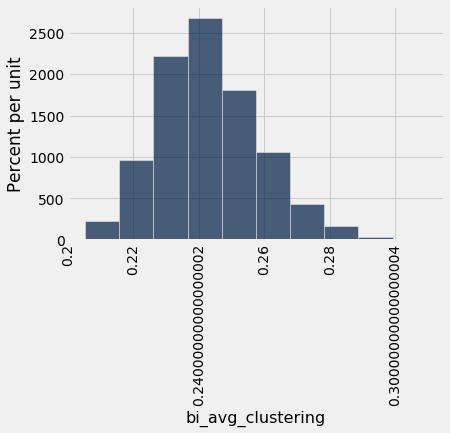

In [28]:
Table().with_column('bi_avg_clustering', bi_avg_clustering).hist()

**Question** Use the distribution of these densities to calculate a $p$ value for the hypothesis that the observed Southern Women's network was generated by a random bipartite network model. (The alternative is that the Southern Women's network has more clustering than the random model would suggest.)

In [29]:
observed_p = np.count_nonzero(bi_avg_clustering >= sw_bi_clustering)/1000
observed_p

0.0

**Question** What does your $p$ value suggest about how plausible your colleague's argument is?

[Answer here]

### Projected networks and thresholding

Finally, we're going to look at how to construct a projected network from a bipartite network.

**Question** Project the Southern Women's network onto the nodes that are women.

In [30]:
women_network = bipartite.projected_graph(sw_net, all_women)

**Question** Plot the network and look at the distribution of degrees (using the `nx.degree` function).

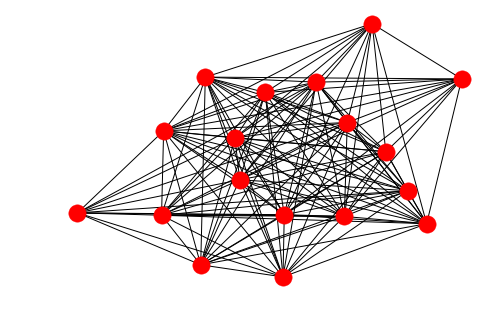

In [31]:
nx.draw(women_network)

In [13]:
nx.degree(women_network)

{'woman_1': 17,
 'woman_10': 17,
 'woman_11': 16,
 'woman_12': 16,
 'woman_13': 17,
 'woman_14': 17,
 'woman_15': 17,
 'woman_16': 16,
 'woman_17': 12,
 'woman_18': 12,
 'woman_2': 15,
 'woman_3': 17,
 'woman_4': 15,
 'woman_5': 11,
 'woman_6': 15,
 'woman_7': 15,
 'woman_8': 16,
 'woman_9': 17}

This network is very highly connected; in fact, it is so highly connected that it is almost uninformative -- basically, the women are all connected to each other.  One way to try and improve the insights we can obtain from a projected network is to keep more information by weighting the edges.

**Question** Project the Southern Women network onto the nodes that are women, weighting each resulting edge by the number of events that were co-attended.

In [32]:
women_network_weighted = bipartite.weighted_projected_graph(sw_net, all_women)

In many cases, it is possible to work directly with a weighted network. In others, it is convenient to turn the weighted network into an unweighted one.  We can turn a weighted network into an unweighted one by picking a threshold above which we will consider two nodes connected.

Here is a function which takes a network with weighted edges and a threshold. It returns a new network that has all edges whose weight is less than the threshold removed. Check it out:

In [36]:
def edge_threshold(net, threshold):
    
    # we'll make a copy of this network so that we don't
    # change the original
    new_net = net.copy()
    
    for e in list(new_net.edges()):
        if new_net[e[0]][e[1]]['weight'] < threshold:
            new_net.remove_edge(e[0], e[1])
    
    return(new_net)

**Question** The loop below is supposed to go through all of the possible threshold values from 1 to 14 and draw the network that results when we only count edges above that threshold. Fill in the missing parts and look at the results:

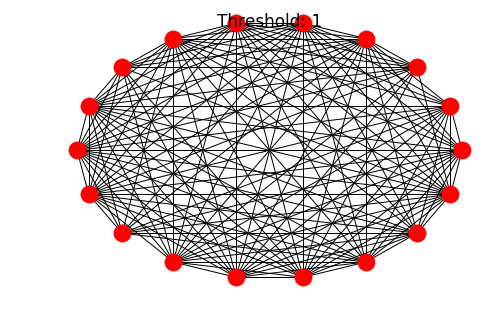

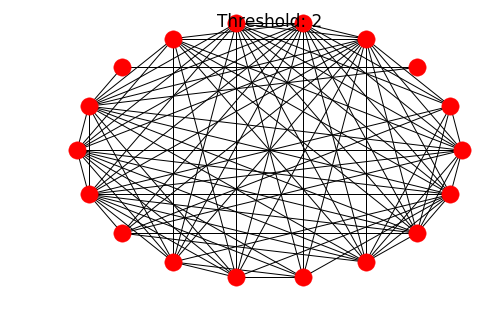

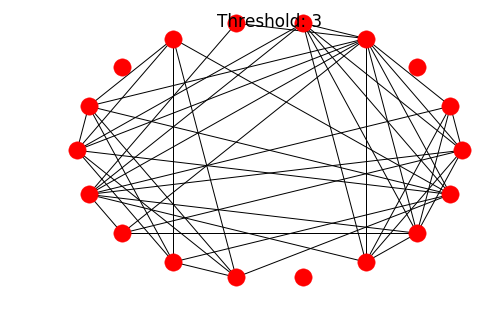

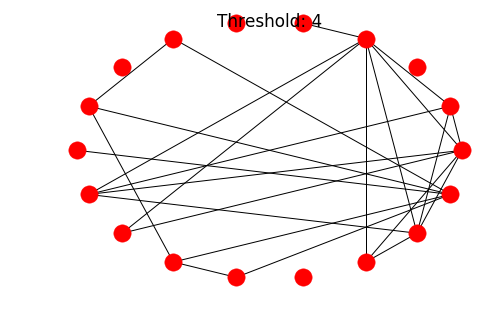

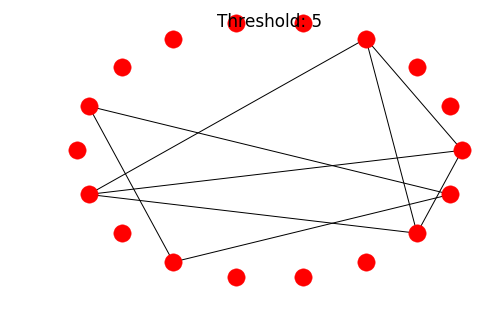

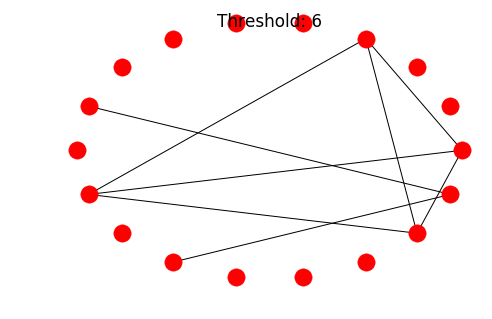

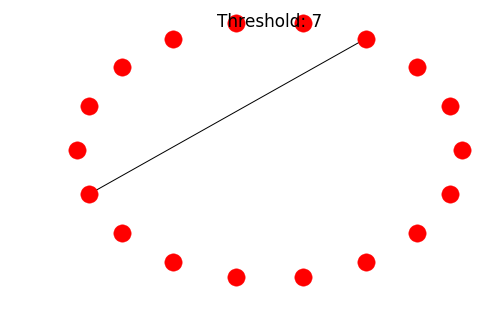

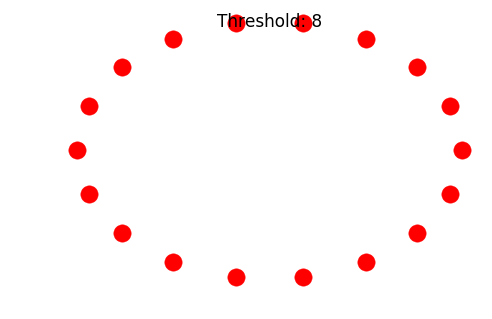

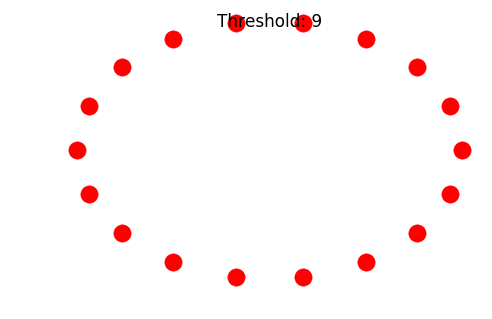

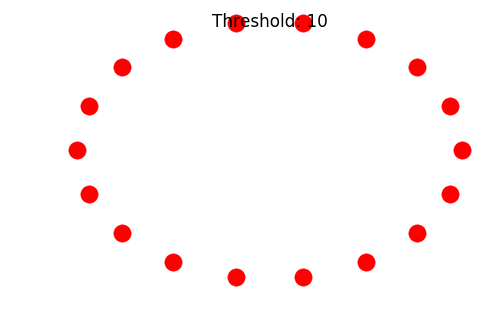

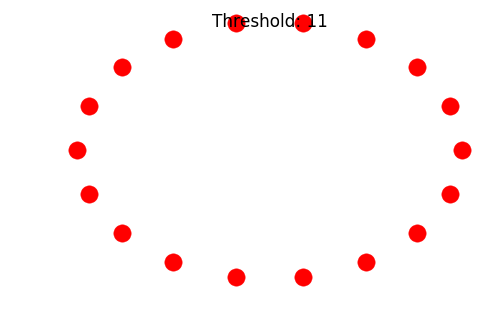

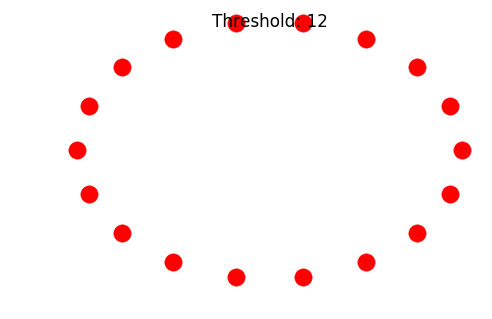

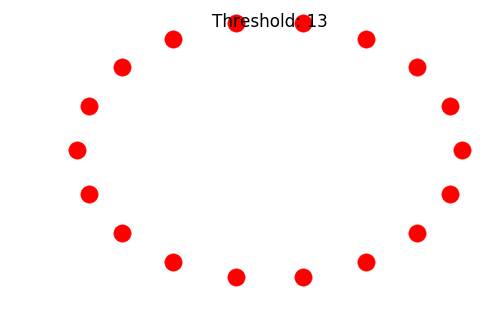

In [37]:
for thresh in range(1, 14):
    this_net = edge_threshold(women_network_weighted, thresh)
    plt.figure()
    plt.suptitle("Threshold: " + str(thresh))
    nx.draw_circular(this_net)

**Question** How much does it seem to matter which threshold you pick? Can you think of a good (principled) reason to pick one threshold value over another?

[Answer here]

## Optional challenge 

Above, we studied clustering in the Southern Women network by using the bipartite average clustering.

An alternate approach would be to study clustering in the projection of the Southern Women network onto the nodes that are women. You will use as a null model the projection of a random bipartite network onto the nodes that are women.

**Optional challenge question** Project the Southern Women network onto the nodes that are women. Threshold the network to 4 events; i.e., consider two women in the projected network connected if they attended at least 4 events together.

In [38]:
proj_sw_women = edge_threshold(women_network_weighted, 4)

**Optional challenge question** Calculate the average clustering coefficient of the projected network (NB: use the standard average clustering coefficient, not the bipartite one -- the projected network is not bipartite.)

In [39]:
sw_proj_clustering = nx.average_clustering(proj_sw_women)
sw_proj_clustering

0.5256613756613757

**Optional challenge question** Write a simulation that generates draws from the null model; that is, simulate, say, 1000 random bipartite networks, project each bipartite network onto the nodes corresponding to the set of women, threshold at 4, and calculate the average clustering coefficient of the projected random network.

In [40]:
proj_avg_clustering = make_array()
threshold_val = 4

for _ in range(1000):
    cur_net = matching_bipartite_random_net(sw_net)
    proj_cur_net = bipartite.weighted_projected_graph(cur_net, all_women)
    proj_cur_net_thresh = edge_threshold(proj_cur_net, threshold_val)
    proj_avg_clustering = np.append(proj_avg_clustering, nx.average_clustering(proj_cur_net_thresh))

**Optional challenge question** Make a histogram of the distribution of the average clustering coefficient under the null model; where would the observed value fall?

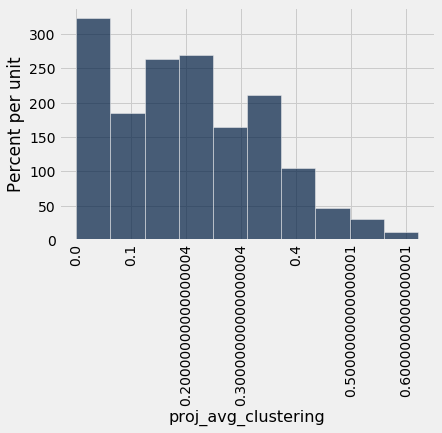

In [41]:
Table().with_column('proj_avg_clustering', proj_avg_clustering).hist()

**Optional challenge question** Compute a $p$ value for the observed value (alternative hypothesis is again that clustering is higher in the Southern Women data than the null model would predict). What would you conclude?

In [42]:
observed_p = np.count_nonzero(proj_avg_clustering >= sw_proj_clustering)/1000
observed_p

0.014